In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

# Method description:
readData: read data from review_pa which only contains business from state PA.

splitData: split dataset to train/test sets according time sequence.

In [3]:
def readData():
  #read data
  review_pa_final=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/final_review_pa.csv", encoding="latin1")
  business=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/business.csv", encoding="latin1")

  #merge review and business
  total_df=review_pa_final.merge(business, on='business_id', how='left', indicator=True)

  df1=total_df.groupby('user_id',as_index=False).apply(lambda x: x.sort_values('date', ascending=True)).reset_index()
  df1['level_1']=df1.index

  return df1

In [4]:
def splitDate(df1,trainRate,testRate):
  df2=df1.copy(deep=True)
  df3=df1.groupby('level_0').count()

  length=list(df3['level_1'])
  # print("length of user:",length)
  


  flag=[0]*sum(length)
  # print(len(flag))
  
  test=testRate
  test_index_end=0
  train=trainRate
  train_index_start=0


  for i in length:
    # print("i:",i)

    train_index_start=test_index_end
    # print("train_index_start:",train_index_start)

    train_index_end=train_index_start+round(i*train)
    # print("train_index_end:",train_index_end)

    flag[train_index_start:train_index_end]=[1]*round(i*train)

    test_index_start=train_index_end
    # print("test_index_start:",test_index_start)

    test_index_end=test_index_start+round(i*test)
    # print("test_index_end:",test_index_end)
    

    flag[test_index_start:test_index_end]=[0]*(round(i*test))

  # print('length of flag:',len(flag))

  # split=pd.Series(flag)
  # df2.info()
  # print(len(flag))
  df2.insert(9,'split',flag,True)
  # df2.info()

  df_train=df2.loc[df2['split']==1]
  df_test=df2.loc[df2['split']==0]

  df_train=df_train.drop(['_merge','split','level_0','level_1'],axis=1)
  df_test=df_test.drop(['_merge','split','level_0','level_1'],axis=1)

  # df_test.info()
  # df_train.info()

  trainFile='train{trainRate:.2f}.csv'
  testFile='test{testRate:.2f}.csv'
  df_train.to_csv(trainFile.format(trainRate=trainRate),index=False)
  df_test.to_csv(testFile.format(testRate=testRate),index=False)
  
  return

In [5]:
#final dataset
df_final=readData()

In [6]:
splitDate(df_final,0.8,0.2)

# Data exploration

In [7]:
#read full business data
business_total=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/business.csv", encoding="latin1")

In [8]:
#read full review data
review=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/review.csv", encoding="latin1")

**Data Set Basic infomation**(before data reduction):

Total no. of unique business: around 150k

Total no. of unique users:around 7 millions

Total no. of reviews:around 2 millions

In [9]:
len(business_total['business_id'].unique())

150346

In [10]:
len(review['review_id'].unique())

6990282

In [11]:
len(review['user_id'].unique())

1987931

Distribution of business in different states

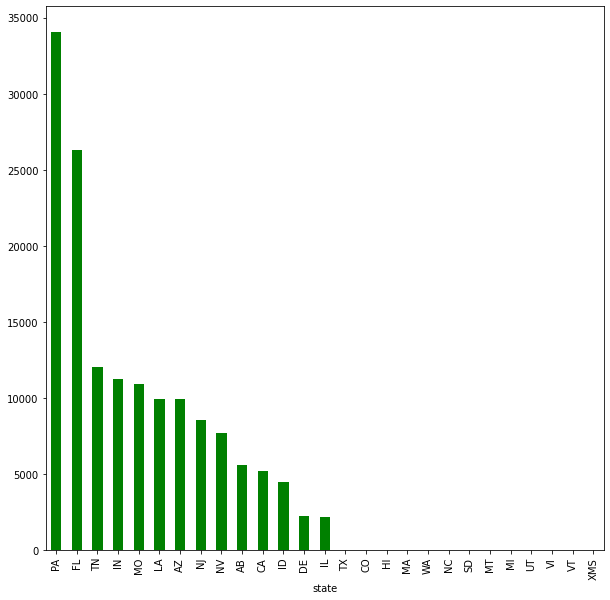

In [12]:
df_groups = business_total.groupby('state').count()
df_state = df_groups['name']
df_state_sorted = df_state.sort_values(ascending = False)
df_state_sorted[:30].plot(kind = 'bar',color='green',figsize=(10,10))
# plt.figure(figsize=(20,20))
plt.show()

Distribution of user-review count

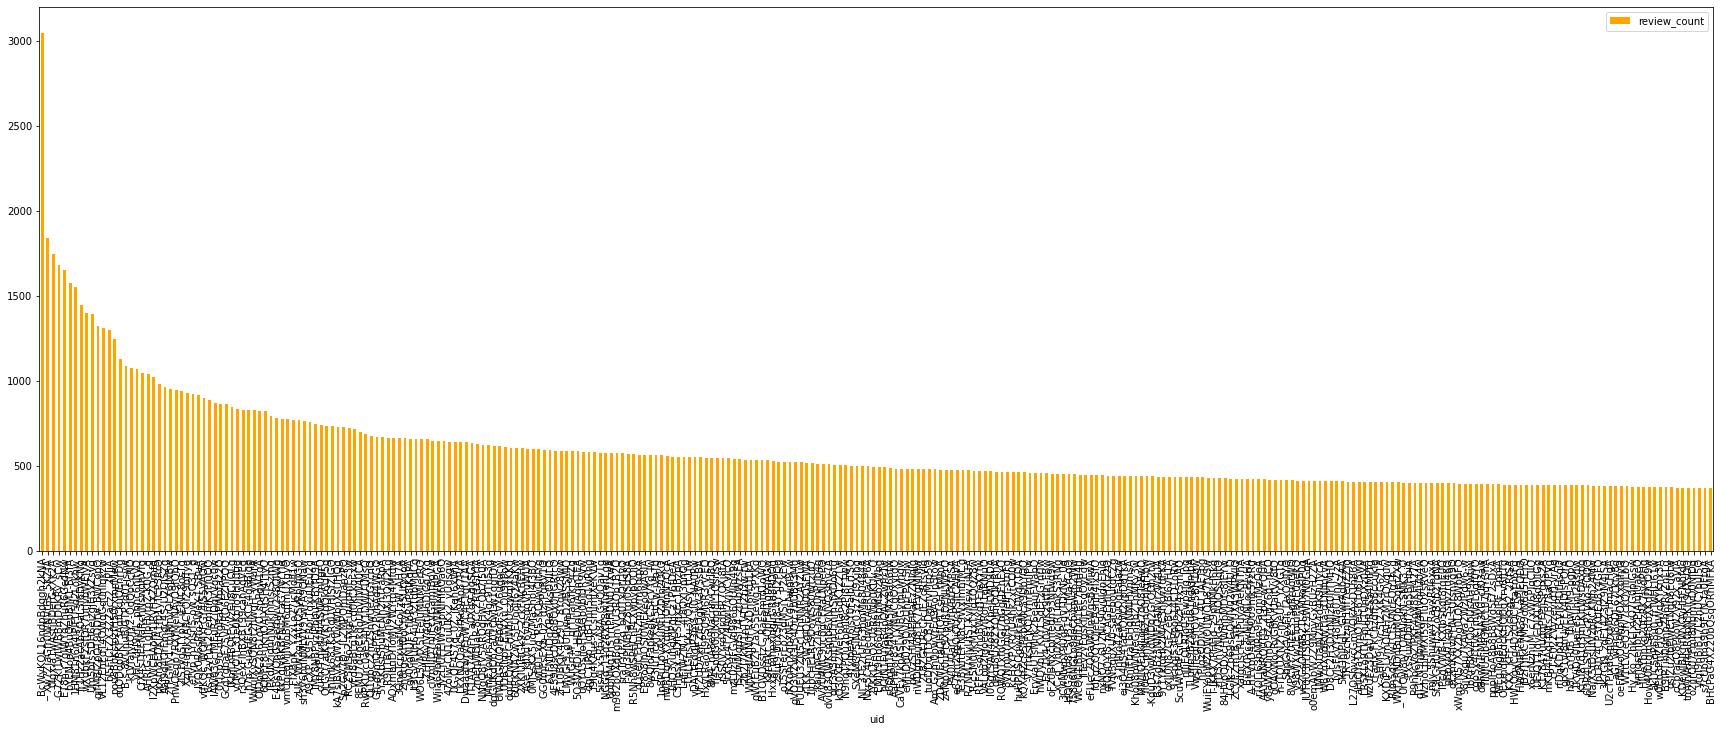

In [13]:
#read full review data
# review_pa=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/review_PA.csv", encoding="latin1")
user=review.groupby('user_id')['user_id'].count().sort_values(ascending=False)
uid=user.index
review_count=user.tolist()
df_review_count=pd.DataFrame({'uid':uid,'review_count':review_count})
df_review_count[0:300].plot.bar(x='uid',y='review_count',color='orange',figsize=(30,10))
plt.show()

In [ ]:
#read full PA review data
# review_pa=pd.read_csv("/content/drive/My Drive/mitb/recommender_system/project2/yeld-dataset/review_PA.csv", encoding="latin1")
# user=review_pa.groupby('user_id')['user_id'].count().sort_values(ascending=False)
# uid=user.index
# review_count=user.tolist()
# df_review_count=pd.DataFrame({'uid':uid,'review_count':review_count})
# df_review_count[0:300].plot.bar(x='uid',y='review_count',color='orange',figsize=(30,10))
# plt.show()

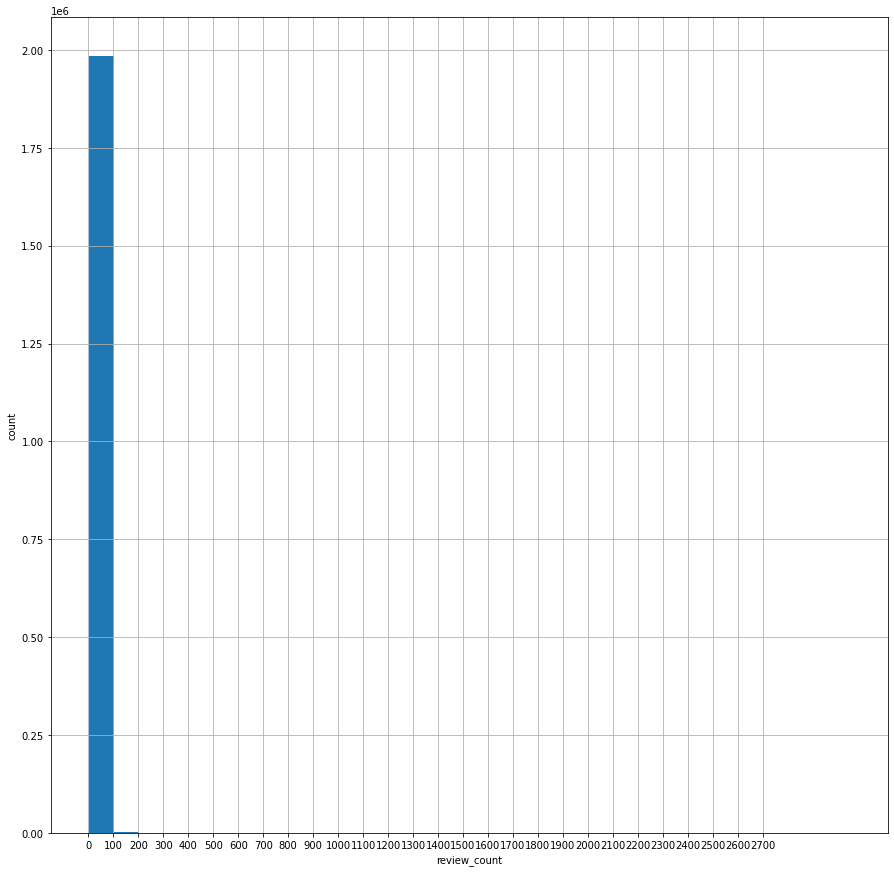

In [14]:
df_review_count['review_count'].hist(bins=30,figsize=(15,15))
x_ticks=np.arange(0,2800,100)
y_ticks=np.arange(0,450000,1000)
plt.xticks(x_ticks)
plt.xlabel('review_count')
plt.ylabel('count')
plt.show()

Distribution of stars

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


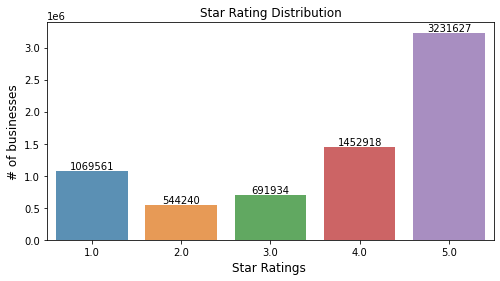

In [15]:
x=review['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sb.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Data reduction:

After data exploration, we only select instances under following conditions:


1.   Businesses from PA
2.   Users who have review less than 100

Basic information of inal dataset used: 

Total no. of unique business: around 32k

Total no. of unique review:around 588k

Total no. of user:around 26k

In [16]:
len(df_final['user_id'].unique())

26763

In [17]:
len(df_final['review_id'].unique())

588270

In [18]:
len(df_final['business_id'].unique())

32223